Цель - провести анализ и подготовить план действий по удержанию клиентов

Задачи:
- загрузить данные
- провести EDA
- построить модель прогнозирования оттока пользователей
- провести кластеризацию пользователей
- сделать выводы и рекомендации

## 1. Данные

Достанем данные из csv-файла и посмотрим на него

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

In [2]:
df = pd.read_csv('/datasets/gym_churn.csv')

In [3]:
df.shape

(4000, 14)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


Приведем закголовки в нижнему регистру

In [5]:
df.columns = map(str.lower, df.columns)

In [6]:
df.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


В таблице 4000 записей с 14 признаками. Все признаки имеют численный формат (int / float).

## 2. EDA

Рассмотрим статистические характеристики датасета в целом и по признаку оттока

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


Таблица содержит следующую информацию о посетителях:
- в среднем соотношение по полу одинаковое
- большинство клиентов работают или проживают недалеко от фитнес-центра
- почти половина клиентов - сотрудники партнеров клуба
- треть клиентов пришли по реферальной программе
- 90% пользователей предоставили данные о своем номере телефона
- в среднем текущие клиенты заключили абонемент на 4,7 месяца
- 41% пользователей посещают групповые занятия
- средний возраст 29 лет, от 18 до 41
- в среднем клиенты тратят на дополнительные услуги 146,9 у.е.
- в среднем до конца действия абонементов текущих пользователей осталось 4,3 месяца
- в среднем клиент посещает фитнес-центр на протяжении 3,7 месяцев
- в неделю клиенты в среднем посещают фитнес-центр 1,87 раз
- за предыдущий месяц клиенты в среднем посещали центр 1,76 раз 

Разделим датасет на действующих клиентов, и тех, кто уже попал в отток и сравним средние по данным группам.

In [8]:
df.groupby('churn').agg('mean')

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


Рассмотрим наглядно соотношение каждого из признаков между активными клиентами и теми, кто ушел.

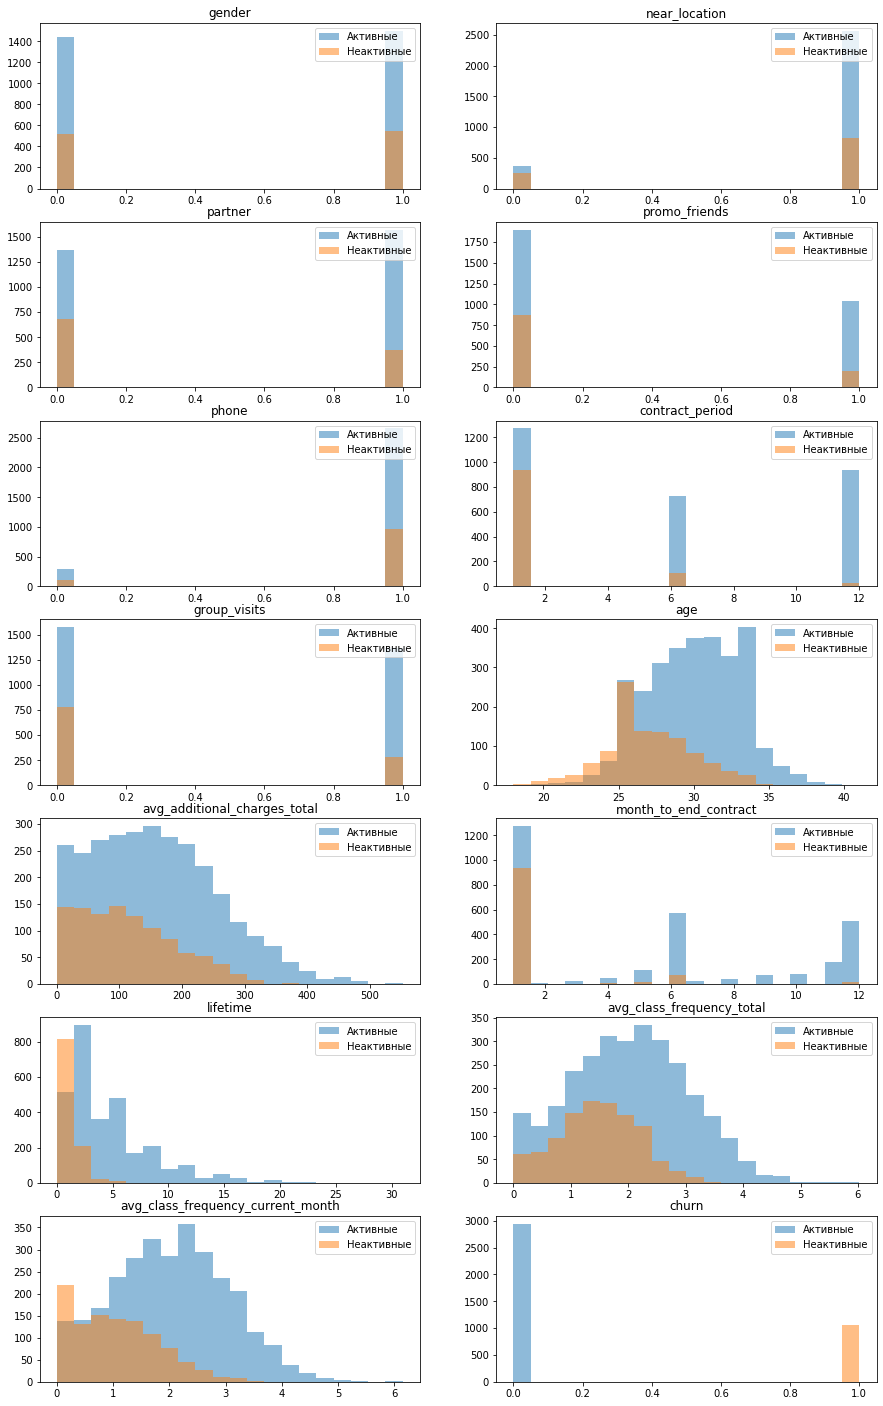

In [9]:
df_churn_0 = df[df['churn'] == 0]
df_churn_1 = df[df['churn'] == 1]

fig, ax = plt.subplots((len(df.columns)+1)//2, 2, figsize=(15,25))
ax = ax.ravel()

for i in range(len(df.columns)):
    col_name = df.columns[i]
    range_hist = (df[col_name].min(), df[col_name].max())
    ax[i].hist(df_churn_0[col_name], bins=20, range = range_hist, alpha = 0.5, label = 'Активные')
    ax[i].hist(df_churn_1[col_name], bins=20, range = range_hist, alpha = 0.5, label = 'Неактивные')
    ax[i].legend(loc='upper right')
    ax[i].set_title(col_name)
plt.show()

Рассмотрим отличия в признаках между группой действующих клиентов с теми, кто перестал пользоваться услугами клуба:
- среди активных клиентов в среднем больше тех, кто ходит в фитнес-клуб поблизости работы или дома
- среди активных клиентов в среднем больше тех, кто является сотрудником партнера фитнес-клуба
- среди активных клиентов в среднем больше тех, кто пришел по реферальному приглашению
- среди активных клиентов в среднем действующий абонемент истекает через 5,7 месяцев против 1,7 тех, кто ушел
- среди активных клиентов в среднем больше доля тех, кто посещает групповые занятия
- в среднем активные клиенты тратят 158 у.е. на доп услуги, а неактивные - 115
- в среднем у активных клиентов абонемент еще действует в течение 5,2 месяцев, тогда как у неактивных - 1,66
- средний возраст клиентов, которые прекратили посещать клуб ниже, чем активных клиентов

Построим матрицу корреляций для имеющихся данных для установления зависимостей между признаками.

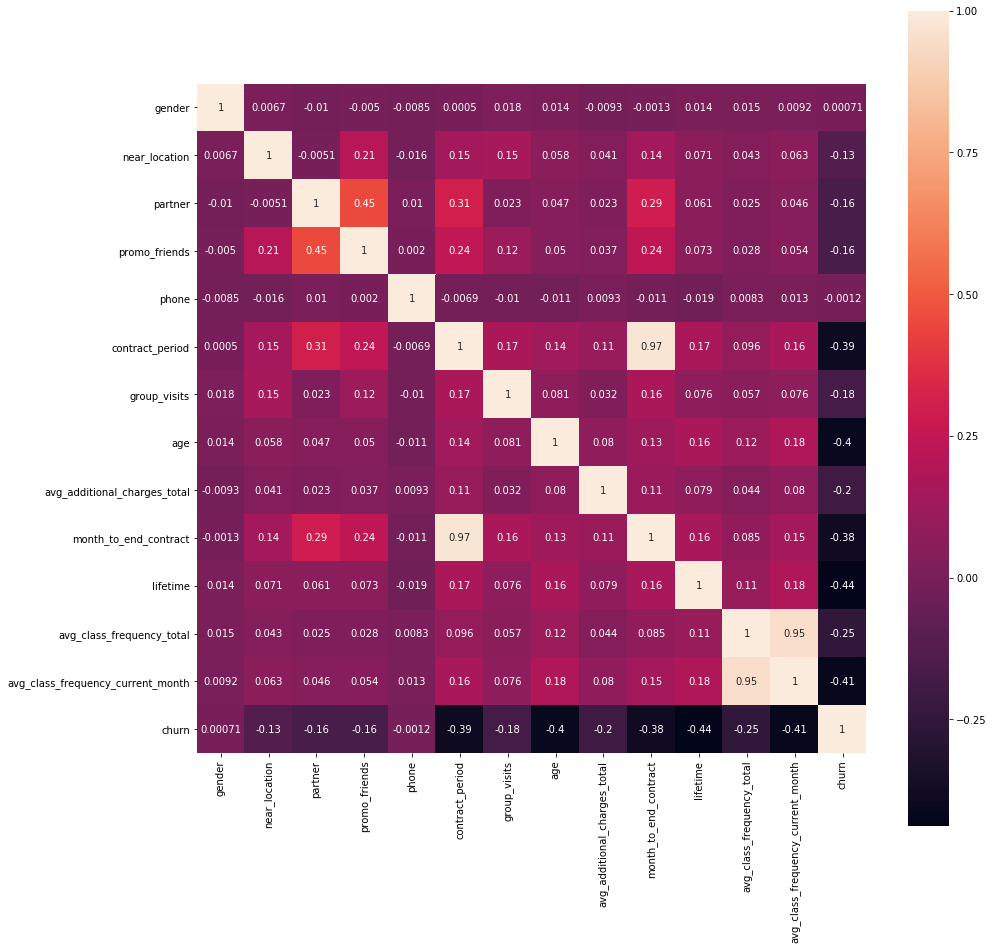

In [10]:
corr_m = df.corr()
plt.figure(figsize=(15,15))
sns.heatmap(corr_m, square=True, annot=True);

Большую корреляцию показывают пары признаков Month_to_end_contract - Contract_period и Avg_class_frequency_total - Avg_class_frequency_current_month. Первая пара указывает на то, что чем больше месяцев до конца действующего абонемента, тем больше текущий абонемент у клиентов. Вторая пара указывает на то, что чем выше средний показатель посещения занятий в неделю в текущем месяце, тем он выше за всю историю наблюдения.

Итоги EDA:
- анализ данных и построенные графики распределения показали отсутствие пропусков и некорретных значений в датасете;
- общая информация по посетителях - равномерное распределение по полу, большинство клиентов предоставили данные о своем контактном номере телефона
- в остальных признаках анализ данных показал отличия между группами активных и неактивных клиентов. Например, среди активных клиентов в среднем больше тех, кто ходит в фитнес-клуб поблизости работы или дома, а также больше тех, кто является сотрудником партнера фитнес-клуба. Кроме того, среди активных клиентов в среднем больше тех, кто пришел по реферальному приглашению и среди активных клиентов в среднем действующий абонемент истекает через 5,7 месяцев против 1,7 тех, кто ушел. Также средний возраст клиентов, которые прекратили посещать клуб ниже, чем активных клиентов
- матрица корреляции указала на взаимосвязь двух пар признаков: Month_to_end_contract - Contract_period и Avg_class_frequency_total - Avg_class_frequency_current_month. 

## 3. Модель прогнозирования оттока пользователей

Ответить на вопросы
- в каких пропорциях?
- как делить - по времени или случайно?
- random_state = 0 (для предотвращения вариативности) и на разделении и на подключении модели
- оценка качества R2

Матрица корреляции указала на наличие взаимозависимых показателей. Исключим параметры Contract_period и Avg_class_frequency_current_month в дальнейшем анализе

In [11]:
df_reg = df.drop(['contract_period', 'avg_class_frequency_current_month'], axis=1)

In [12]:
df_reg.head()

,gender,near_location,partner,promo_friends,phone,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,churn
0,1,1,1,1,0,1,29,14.227470,5.0,3,0.020398,0
1,0,1,0,0,1,1,31,113.202938,12.0,7,1.922936,0
2,0,1,1,0,1,0,28,129.448479,1.0,2,1.859098,0
3,0,1,1,1,1,1,33,62.669863,12.0,2,3.205633,0
4,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,0


Разделим данные на обучающую и валидационную выборки

In [13]:
X = df_reg.drop('churn', axis=1)

In [14]:
y = df['churn']

Разделим на обучающую и валидационную выборку

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Стандартизируем данные и обучим модель с помощью логистической регрессии и случайного леса. Сравним результаты с помощью метрик accuracy, precision и recall

In [16]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [17]:
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

Логистическая регрессия

In [18]:
lr_model = LogisticRegression(random_state=0)
lr_model.fit(X_train_st, y_train)
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:,1]

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Случайный лес

In [19]:
rf_model = RandomForestClassifier(n_estimators = 100, random_state=0)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1]

Зададим функцию для вывода метрик для каждой модели

In [20]:
def print_all_metrics(y_true, y_pred, y_proba, title = 'Метрики классификации'):
    print(title)
    print('Accuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('Precision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('Recall: {:.2f}'.format(recall_score(y_true, y_pred)))

In [21]:
print_all_metrics(y_test, lr_predictions, lr_probabilities , title='Метрики для модели логистической регрессии:')

Метрики для модели логистической регрессии:
Accuracy: 0.90
Precision: 0.79
Recall: 0.81


In [22]:
print_all_metrics(y_test, rf_predictions, rf_probabilities, title = 'Метрики для модели случайного леса:')

Метрики для модели случайного леса:
Accuracy: 0.26
Precision: 0.25
Recall: 1.00


Доля правильных ответов (Accuracy):
- в модели логистической регрессии точность составила 90%, что является хорошим показателем и значительно превосходит результат модели случайного леса с показателем 26%

Точность (Precision):
- точность модели логистической регрессии также оказалась выше модели случайного леса 79% против 25%

Полнота (Recall):
- показатель полноты оказался выше у модели случайного леса 100%, а у модели логистической регрессии 81%

Полученные результаты дают понять, что модель логистической регресии проявила себя лучше на валидационных данных. Несмотря на то, что показатель полноты оказался меньше, чем у модели случайного леса, сбалансированность между показателями Precision и Recall указывает на более точный подход этой модели в описании данных и прогнозировании целевой переменной.

## 4. Кластеризация пользователей

В рамках данного блока пошагово выполним ряд задач:
- стандартизируем данные
- построим матрицу расстояний
- нарисуем дендограмму
- применим алгоритм K-Means для обучения модели кластеризации
- рассмотрим средние значения для признаков в кластерах
- построим распределение признаков для кластеров
- для каждого полученного кластера посчитаем долю оттока 

In [23]:
sc = StandardScaler()

In [24]:
x_sc = sc.fit_transform(X)

In [25]:
linked = linkage(x_sc, method = 'ward')

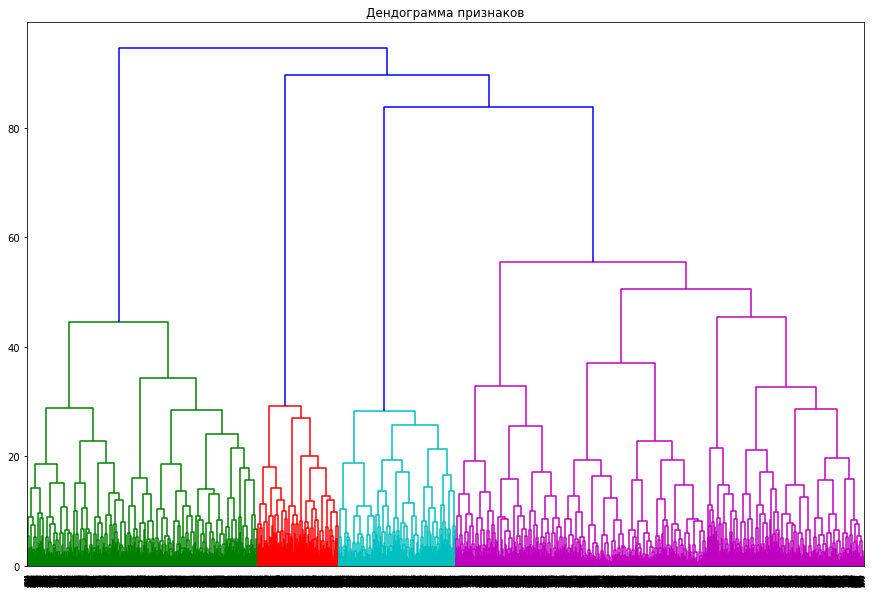

In [26]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Дендограмма признаков')
plt.show()

Дендограмма признаков построена на основе матрицы расстояний linked. Она позволяет подобрать необходимое количество число кластеров. Для дальнейшего исследования возьмем количество кластеров, равное 5

In [27]:
km = KMeans(n_clusters = 5)

In [28]:
labels = km.fit_predict(x_sc)

In [29]:
df_reg['cluster_km'] = labels

In [30]:
df_reg.groupby(['cluster_km']).mean()

,gender,near_location,partner,promo_friends,phone,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,churn
cluster_km,,,,,,,,,,,,
0,0.539349,0.995803,0.391396,0.018888,1.0,0.543547,30.824764,179.449230,5.867786,5.590766,2.316583,0.020986
1,0.496988,0.994980,0.895582,0.997992,1.0,0.520080,29.507028,151.579232,6.300201,4.176707,1.943522,0.133534
2,0.497292,1.000000,0.205776,0.055054,1.0,0.287906,27.694043,120.630840,1.929603,2.013538,1.511817,0.524368
3,0.523316,0.862694,0.471503,0.305699,0.0,0.427461,29.297927,144.208179,4.466321,3.940415,1.854211,0.266839
4,0.500898,0.000000,0.488330,0.077199,1.0,0.231598,28.685817,137.277472,2.804309,2.978456,1.762672,0.402154


Построим распределения по признакам

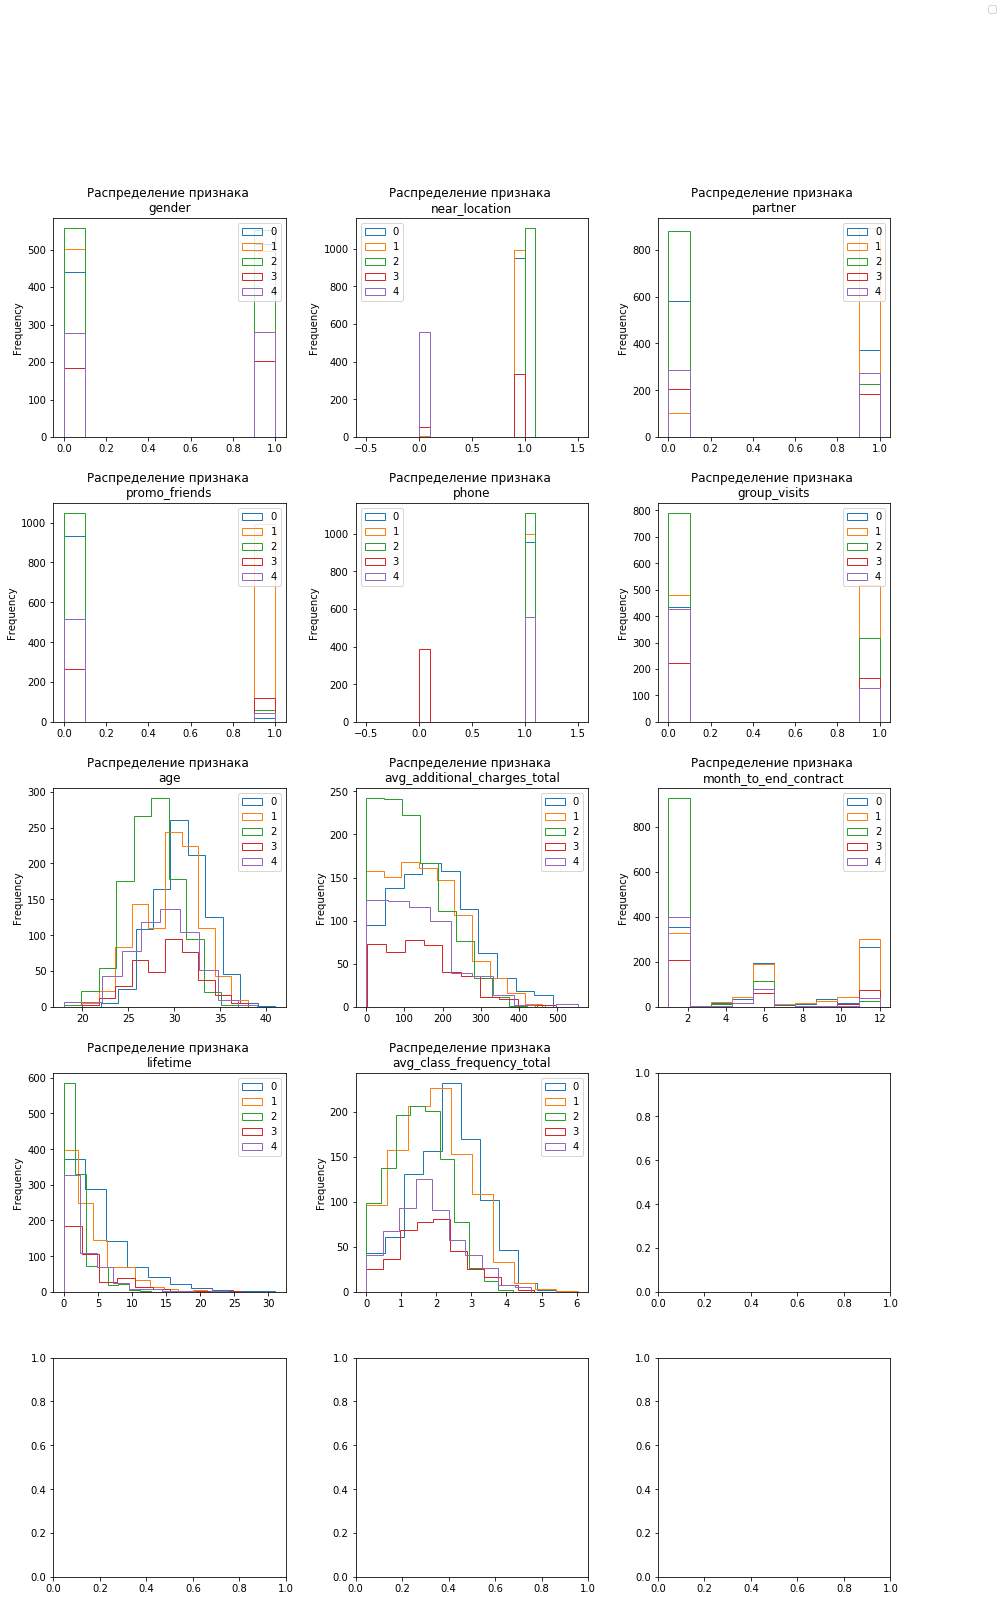

In [31]:
fig, ax = plt.subplots(5, 3, figsize=(15,25))
ax = ax.flatten()
plt.subplots_adjust(wspace=0.3, hspace=0.3)
 
for i, col in enumerate(df_reg.drop(['churn', 'cluster_km'], axis=1)):
    df_reg.groupby('cluster_km')[col].plot(kind='hist', alpha=1, histtype = 'step', 
                                          title='Распределение признака \n'+ str(col),
                                          ax = ax[i], legend= True)

handles, labels = ax[12].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
 
plt.show()

Рассмотрим долю оттока для каждого кластера

In [32]:
df_reg.groupby('cluster_km')['churn'].agg('mean')

cluster_km
0    0.020986
1    0.133534
2    0.524368
3    0.266839
4    0.402154
Name: churn, dtype: float64

Матрица средних значений признаков, графики распределения признаков и показатели оттока для каждого кластера демонстрируют следующие особенности разделения пользователей по кластерам:
- разделение по полу почти равномерное
- по удаленности фитнес центров выделен кластер 2 с пользователями, для которых фитнес-центр не расположен рядом с домом или работой
- по партнероской программе выделен кластер 1 с пользователями, которых пригласили друзья
- по признаку без телефона выделен кластер 4
- в групповых занятиях пользователи кластера 1 не посещают их, а в кластере 1 наоборот
- по возврату распределение равномерное, около 29 лет
- по дополнительным затратам нельзя однозначно определить различие между кластерами, но в группе 0 средний чек наибольший, в 2 - наименьший
- по признаку количества месяцев до конца абонемента среднее значение у кластера 0 наибольшее, у кластера 2 - наименьшее
- срок "жизни" клиентов в кластере 0 наибольший, в кластере 2 - наименьишй
- среднее количество посещений за весь период в кластере 2 наименьшее
- целевой показатель указывает на то, что доля ушедших пользователей в кластере 2 наибольшая, в 0 - наименьшая

## 5. Выводы и рекомендации

Выводы:
- в исходной таблице хранится 4000 записей с 14 признаками. Все признаки имеют численный формат (int / float);
- таблица содержит следующую информацию о посетителях: 
    - среднее отношение по полу одинаковое
    - большинство клиентов работают или проживают недалеко от фитнес-центра
    - почти половина клиентов - сотрудники партнеров клуба
    - треть клиентов пришли по реферальной программе
    - 90% пользователей предоставили данные о своем номере телефона
    - 41% пользователей посещают групповые занятия
    - средний возраст 29 лет
    - в среднем до конца действия абонементов текущих пользователей осталось 4,3 месяца
    - в среднем клиент посещает фитнес-центр на протяжении 3,7 месяцев
    - в неделю клиенты в среднем посещают фитнес-центр 1,87 раз
    - за предыдущий месяц клиенты в среднем посещают центр 1,76 раз;
- отличия в признаках между группой действующих клиентов и теми, кто перестал пользоваться услугами клуба:
    - среди активных клиентов в среднем больше тех, кто ходит в фитнес-клуб поблизости работы или дома
    - среди активных клиентов в среднем больше тех, кто является сотрудником партнера фитнес-клуба
    - среди активных клиентов в среднем больше тех, кто пришел по реферальному приглашению
    - среди активных клиентов в среднем действующий абонемент истекает через 5,7 месяцев против 1,7 тех, кто ушел
    - среди активных клиентов в среднем больше доля тех, кто посещает групповые занятия
    - в среднем активные клиенты тратят 158 у.е. на доп услуги, а неактивные - 115
    - в среднем у активных клиентов абонемент еще действует в течение 5,2 месяцев, тогда как у неактивных - 1,66
    - средний возраст клиентов, которые прекратили посещать клуб ниже, чем активных клиентов
- матрица корреляции указала на взаимосвязь двух пар признаков: Month_to_end_contract - Contract_period и Avg_class_frequency_total - Avg_class_frequency_current_month;
- модель логистической регресии проявила себя лучше на валидационных данных, чем модель случайного леса. Несмотря на то, что показатель полноты оказался меньше, чем у модели случайного леса, сбалансированность между показателями Precision и Recall указывает на более точный подход этой модели в описании данных и прогнозировании целевой переменной;
- матрица средних значений признаков, графики распределения признаков и показатели оттока для каждого кластера демонстрируют следующие особенности разделения пользователей по кластерам:
    - разделение по полу почти равномерное
    - по удаленности фитнес центров выделен кластер 2 с пользователями, для которых фитнес-центр не расположен рядом с домом или работой
    - по партнероской программе выделен кластер 1 с пользователями, которых пригласили друзья
    - по признаку без телефона выделен кластер 4
    - в групповых занятиях пользователи кластера 1 не посещают их, а в кластере 1 наоборот
    - по возврату распределение равномерное, около 29 лет
    - по дополнительным затратам нельзя однозначно определить различие между кластерами, но в группе 0 средний чек наибольший, в 2 - наименьший
    - по признаку количества месяцев до конца абонемента среднее значение у кластера 0 наибольшее, у кластера 2 - наименьшее
    - срок "жизни" клиентов в кластере 0 наибольший, в кластере 2 - наименьишй
    - среднее количество посещений за весь период в кластере 2 наименьшее
    - целевой показатель указывает на то, что доля ушедших пользователей в кластере 2 наибольшая, в 0 - наименьшая

Рекомендации. При прогнозировании оттока и маркетинговых решениях необходимо учитывать следующие:
- уделять больше внимания привлечению пользователей, работающих или проживающих в непосредственной близости от фитнес-центра;
- расширять партнерские и реферальные программы, которые повышают лояльность клиентов;
- предлагать клиентам к покупке абонементы 6 и 12 месяцев;
- продвигать программы групповых занятий